## Pytorch transfer learning

Transfer learning involves taking a pre-trained neural network and adapting the neural network to a new, different data set.

* Pretrained model = Foundation Model

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Set device
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
!nvidia-smi

Wed Jan  3 10:02:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8                9W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get data 


In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path  = Path('data/')
image_path = data_path / 'pizza_steak_sushi'


def download_data(url: str,):
    
    if image_path.is_dir():
        print(f"[INFO] {image_path} already exists.")
    else:
        print(f"[INFO] Did not find {image_path}, creating directory...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
            request = requests.get(url)
            print(f"[INFO] Downloading {request.url} ...")
            f.write(request.content)
            
        # Unzip data
        with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
            print("[INFO] Unzipping data...")
            zip_ref.extractall(image_path)

download_data('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')

[INFO] data\pizza_steak_sushi already exists.


In [5]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## Create Datasets and Dataloaders

Turn the data into PyTorch DataLoaders using the `data_setup.py` and `create_dataloaders()` function

There is two ways to do this:
1. Manually created transforms - define how the data should be transformed
2. Automatically created transforms - the transforms are defined by the model

**Important Point**: When using a pretrained model, it is important that the data (even custom data) pass through its transformed in the same way the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) within `torchvision`

Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

In [6]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,]) # make sure images are normalized the same way as when the model was trained on them

In [7]:

from torchvision import datasets, transforms
from going_modular import data_setup

# Create data loaders

train_dataloader, test_dataloader, class_names  = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir= test_dir,
    transform = manual_transforms,
    batch_size = 32,
    num_workers = 4)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x231c9ba5dd0>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models` (auto creation)

As of `torchvision v0.13+` there is now support for automatic 

In [8]:
# Get a set of pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create data loaders using the same transforms as the pretrained model
train_dataloader, test_dataloader, class_names  = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir= test_dir,
    transform = auto_transforms,
    batch_size = 32,
    num_workers = 4)

train_dataloader, test_dataloader, class_names 

(<torch.utils.data.dataloader.DataLoader at 0x231c9bb9a10>,
 ['pizza', 'steak', 'sushi'])

### 3. Get a pretrained model

There are various places to get a pretrained model such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace
4. Paperswithcode

#### 3.1 Which pretrained model should be used?

**Experiment, Experiment, Experiment**

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your problem

Three things to consider:
1. Speed
2. Performance
3. Size



In [11]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of the model with `torchinfo.summary()`

In [13]:
# Print summary of model
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and customizing the head of the model

With a `feature extractor` model, typically you will "freeze" the base layers of a pretrained model and update the output layers to match data problem

In [14]:
# Freeze all of the base layers in EfficientNet0
for param in model.features.parameters():
    param.requires_grad = False

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [15]:
# Update the classifier head of our model to suit the problem
from collections import OrderedDict
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280, 
        out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 4. Train the model

In [17]:
# Define the loss and optimizer
import torch.nn as nn
import torch
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
from going_modular import engine
from timeit import default_timer as timer

start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device)

end_time = timer()
total_time = end_time - start_time

print(f"[INFO] Total time: {total_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0744 | train_acc: 0.4297 | test_loss: 0.8571 | test_acc: 0.7036
Epoch: 2 | train_loss: 0.8568 | train_acc: 0.7070 | test_loss: 0.7125 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7570 | train_acc: 0.7539 | test_loss: 0.6028 | test_acc: 0.8958
Epoch: 4 | train_loss: 0.6672 | train_acc: 0.8984 | test_loss: 0.6214 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6757 | train_acc: 0.7969 | test_loss: 0.6279 | test_acc: 0.7642
[INFO] Total time: 54.90 seconds


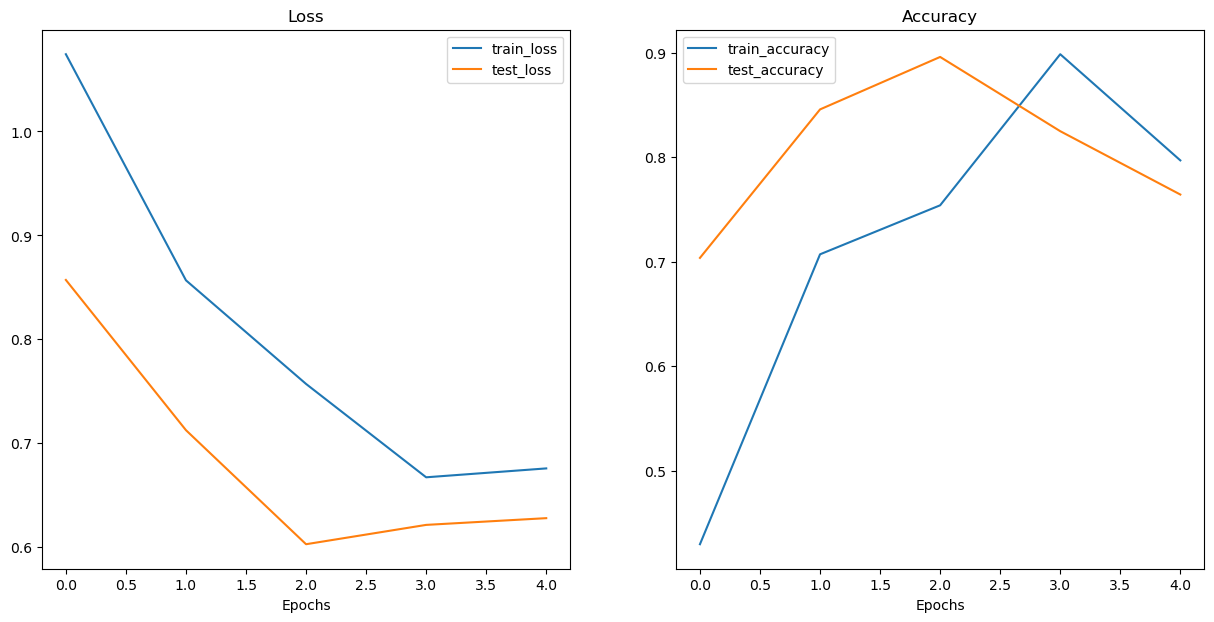

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(results
)


### 6. Make predictions on images from the test dataset

Adhere to the data explorers motto of *visualize, visualize, visualize!*

Things to keep in mind when making predictions

Data needs to be:
* Same shape
* Same datatype
* Same device
* Same type

Create a function to make a prediction and plot it
1. Take in The trained model, a list of class names, a file path to a target image, an image size, a transform, and a target device
2. open image with `PIL.Image.Open()`
3. Create a transform if one does not exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference 
6. Transform the target image and make aligns its dimensionality
7. Make a prediction to the model
8. Convert the model's output logits to pred_probs using `torch.softmax()`
9. Convert pred_prods to labels using `torch.argmax()`
10. Plot the image with matplotlib and set the title to pred_label



In [78]:
import torch
import torchvision
from typing import List, Tuple
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_and_plot(
                    model: torch.nn.Module,
                    class_names: List[str],
                    file_path: str,
                    transform: transforms.Compose = None,
                    img_size: Tuple[int, int] = (224, 224),
                    device: torch.device = device):
    
    # Read in the image from file_path
    image = Image.open(file_path)
    
    # Preprocess the image to match the expected input of the model
    if transform:
        image_transform = transform
    else:
        normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        
        image_transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                normalize,])
    # Set model to device
    model.to(device)
    
    # Set model into evaluation mode
    model.eval()
    with torch.inference_mode():
        
        # Make predictions
        image_transform = image_transform(image).unsqueeze(dim=0).to(device)
        preds = model(image_transform)
        pred_probs = torch.softmax(preds, dim=1)
        #print(pred_probs)
        pred_labels = torch.argmax(pred_probs, dim=1)
        #print(pred_labels)
        
        # Plot the image

        plt.figure(figsize=(10, 7))
        plt.imshow(image)
        plt.title(f"Prediction: {class_names[pred_labels]} | Probability: {pred_probs.max():.3f}")
        plt.axis(False)


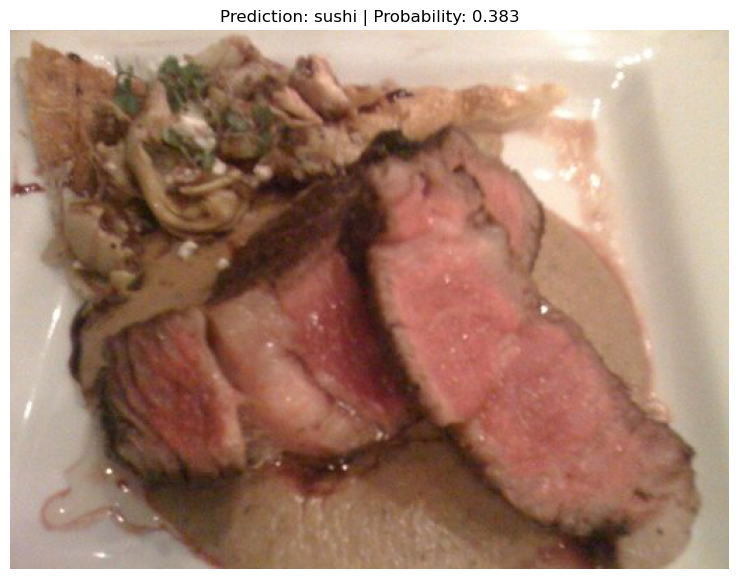

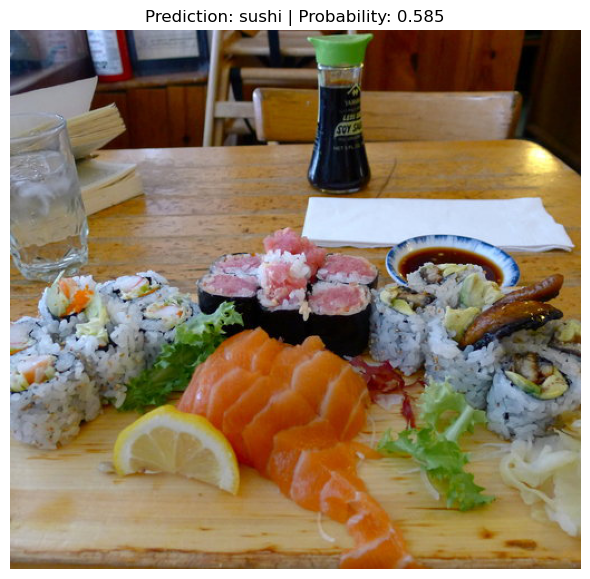

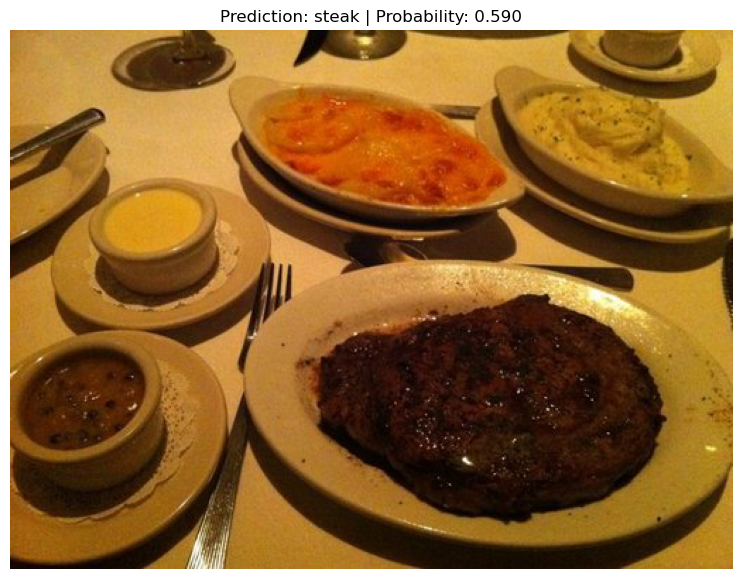

In [83]:
# Get a random image from the test dataset
from cgi import test
import random
from PIL import Image
import matplotlib.pyplot as plt
num_images = 3
test_image_path = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path, num_images)
test_image_path_sample 

for image_path in test_image_path_sample:
    predict_and_plot(
            model=model,
            class_names=class_names,
            file_path=image_path,
            transform=auto_transforms,
            img_size=(224, 224),
            device=device
    )


### Making predictions on custom images


In [84]:
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download custom image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        f.write(request.content)
        print(f"Downloaded {custom_image_path}")
else:
    print(f"Found {custom_image_path}")
    

Found data\04-pizza-dad.jpeg


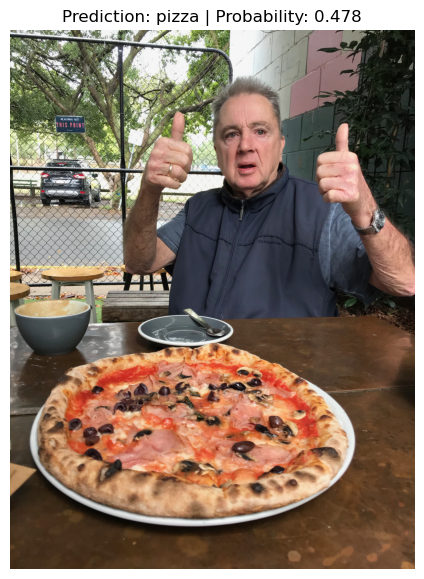

In [85]:
predict_and_plot(model=model,
                class_names=class_names,
                file_path=custom_image_path,
                transform=auto_transforms,
                img_size=(224, 224),
                device=device)